### ZoKrates Benchmarking

#### Functionality:
This notebook benchmarks the gas costs for different .code functions. By setting __max_inputs__ programms with __[1 - max_inputs]__ will be generated.

E.g.
__max_inputs = 3__ will generate the following programms, deploy and execute them, and plot the gas usage for each programm

```
def main(field a):
	 return a

def main(field a, field b):
	 return a, b

def main(field a, field b, field c):
	 return a, b, c
```

#### Requirements for running:
- Ganache or similar blockchain client running
- ZoKrates is installed locally (via install script)
- solc is installed globally (npm i -g solc)



### Installing Dependencies:


In [130]:
import sys
!{sys.executable} -m pip install web3
!{sys.executable} -m pip install matplotlib

### Imports

In [131]:
import json
import matplotlib.pyplot as plt
from web3 import Web3
w3 = Web3(Web3.HTTPProvider("http://127.0.0.1:8545"))
w3.eth.defaultAccount = w3.eth.accounts[0]

Matplotlib is building the font cache using fc-list. This may take a moment.


### Set Max Inputs:
Set max number of inputs for the function 

In [142]:
max_inputs = 25
proving_scheme = "g16"

### Generate ZoKrates Benchmark files:

In [147]:
# function for naming function parameters with chars. Converts number to char [a-z].
# 1 -> a, 26 -> z, 27 -> za
def name_inputs(num, acc=""):
    if num > 26:
        acc += chr(122)
        return name_inputs(num - 26, acc)
    else:
        return acc + chr(num + 96)

# generates valid ZoKrates functions with given number of inputs
def generate_function(input_num):
    function_name = 'def main('
    function = "\n\t return "
    function_return = " -> (" + "field, " * (input_num - 1) + "field):"
    if input_num == 1:
        function_name = "def main(field a)"
        function = "\n\t return a"
    else:
        for i in range(1, input_num + 1):
            if i != input_num:
                function_name += ('field ' + name_inputs(i) + ', ')
                function += name_inputs(i) + ", "
            else:
                function_name += ('field ' + name_inputs(i) + ')')
                function += name_inputs(i)

    write_files(function_name + function_return + function, input_num)
    
# writes .code files
def write_files(content, input_num):
    file = open(str(input_num) + "-benchmark.code", "w")
    file.write(content)
    file.close()

# Generates test .code files based on max_input
for i in range(1, max_inputs + 1):
    generate_function(i)
print("Success! Files have been created")




Success! Files have been created


### Compile and deploy

In [144]:
results_deploy = []
results_verify = []

for i in range(1, max_inputs + 1):
    params = '3 '*i
    file = str(i) + '-benchmark.code'
    !zokrates compile -i {i}-benchmark.code --light
    !zokrates setup -s {proving_scheme}
    !zokrates compute-witness -a {params}
    !zokrates generate-proof -s {proving_scheme}
    !zokrates export-verifier -s {proving_scheme} -a v2
#   Compiling contract via solc cli
    !solcjs --abi --bin verifier.sol
    deploy_and_call()
    
def deploy_and_call():
    data = get_proof() 
    
#   Deploy Contract:
    bytecode = open('verifier_sol_Verifier.bin', 'r').read()
    abi = open('verifier_sol_Verifier.abi', 'r').read()
    contract = w3.eth.contract(abi=abi, bytecode=bytecode)
    tx_hash = contract.constructor().transact()
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    results_deploy.append(tx_receipt.gasUsed)
    contract = w3.eth.contract(address=tx_receipt.contractAddress, abi=abi)
    
#   Call verify function
    tx_hash = contract.functions.verifyTx(data[0], data[1]).transact()
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    results_verify.append(tx_receipt.gasUsed)
    
def get_proof():
    with open('proof.json') as f:
        data = json.load(f)
        f.close()
        return (format_proof(data['proof']), format_inputs(data['inputs']) 
                
#  convert inputs from hex to decimal
def format_inputs(inputs):
    res = []
    for i in inputs:
        res.append(int(i, 16))
    return res
    
# formats and returns proof data as decimal tuple
def format_proof(proof):
    converted = []
    for key in proof.keys():
        res = []
        converted.append(format_array(proof[key], res))       
    return tuple(converted)
    
# recursive function for converting the proof data from hex to decimal (needed because of web3.py) while keeping the nested nature of proof data
# only tested for g16 (because the only proof currently available with install script) but should work for any type of scheme
def format_array(arr, res = [], idx = None):
    for elem in arr:
        if type(elem) != list:
            if idx != None:
                res[idx].append(int(elem, 16))
            else:
                res.append(int(elem, 16))
        else:
            res.append([])
            format_array(elem, res, len(res)-1)
    return res
            

print(results_deploy)
print(results_verify)



Compiling 1-benchmark.code

Compiled code written to 'out'
Number of constraints: 1
Performing setup...
def main(_0) -> (1):
	(1 * ~one) * (1 * _0) == 1 * ~out_0
	 return ~out_0
Has generated 3 points
Computing witness...
def main(_0) -> (1):
	(1 * ~one) * (1 * _0) == 1 * ~out_0
	 return ~out_0

Witness: 

~out_0 3
Generating proof...
generate-proof successful: true
Exporting verifier...
Finished exporting verifier.
verifier.sol:402:1: Warning: Experimental features are turned on. Do not use experimental features on live deployments.
pragma experimental ABIEncoderV2;
^-------------------------------^

verifier.sol:450:5: Warning: Function state mutability can be restricted to view
    function addition(G2Point memory p1, G2Point memory p2) internal returns (G2Point memory r) {
    ^ (Relevant source part starts here and spans across multiple lines).

Compiling 2-benchmark.code

Compiled code written to 'out'
Number of constraints: 2
Performing setup...
def main(_0, _1) -> (2):
	(1 * ~o

Exporting verifier...
Finished exporting verifier.
verifier.sol:402:1: Warning: Experimental features are turned on. Do not use experimental features on live deployments.
pragma experimental ABIEncoderV2;
^-------------------------------^

verifier.sol:450:5: Warning: Function state mutability can be restricted to view
    function addition(G2Point memory p1, G2Point memory p2) internal returns (G2Point memory r) {
    ^ (Relevant source part starts here and spans across multiple lines).

Compiling 7-benchmark.code

Compiled code written to 'out'
Number of constraints: 7
Performing setup...
def main(_0, _1, _2, _3, _4, _5, _6) -> (7):
	(1 * ~one) * (1 * _0) == 1 * ~out_0
	(1 * ~one) * (1 * _1) == 1 * ~out_1
	(1 * ~one) * (1 * _2) == 1 * ~out_2
	(1 * ~one) * (1 * _3) == 1 * ~out_3
	(1 * ~one) * (1 * _4) == 1 * ~out_4
	(1 * ~one) * (1 * _5) == 1 * ~out_5
	(1 * ~one) * (1 * _6) == 1 * ~out_6
	 return ~out_0, ~out_1, ~out_2, ~out_3, ~out_4, ~out_5, ~out_6
Has generated 15 points
Computing 

Compiling 11-benchmark.code

Compiled code written to 'out'
Number of constraints: 11
Performing setup...
def main(_0, _1, _2, _3, _4, _5, _6, _7, _8, _9, _10) -> (11):
	(1 * ~one) * (1 * _0) == 1 * ~out_0
	(1 * ~one) * (1 * _1) == 1 * ~out_1
	(1 * ~one) * (1 * _2) == 1 * ~out_2
	(1 * ~one) * (1 * _3) == 1 * ~out_3
	(1 * ~one) * (1 * _4) == 1 * ~out_4
	(1 * ~one) * (1 * _5) == 1 * ~out_5
	(1 * ~one) * (1 * _6) == 1 * ~out_6
	(1 * ~one) * (1 * _7) == 1 * ~out_7
	(1 * ~one) * (1 * _8) == 1 * ~out_8
	(1 * ~one) * (1 * _9) == 1 * ~out_9
	(1 * ~one) * (1 * _10) == 1 * ~out_10
	 return ~out_0, ~out_1, ~out_2, ~out_3, ~out_4, ~out_5, ~out_6, ~out_7, ~out_8, ~out_9, ~out_10
Has generated 23 points
Computing witness...
def main(_0, _1, _2, _3, _4, _5, _6, _7, _8, _9, _10) -> (11):
	(1 * ~one) * (1 * _0) == 1 * ~out_0
	(1 * ~one) * (1 * _1) == 1 * ~out_1
	(1 * ~one) * (1 * _2) == 1 * ~out_2
	(1 * ~one) * (1 * _3) == 1 * ~out_3
	(1 * ~one) * (1 * _4) == 1 * ~out_4
	(1 * ~one) * (1 * _5) == 1 * ~o

Generating proof...
generate-proof successful: true
Exporting verifier...
Finished exporting verifier.
verifier.sol:402:1: Warning: Experimental features are turned on. Do not use experimental features on live deployments.
pragma experimental ABIEncoderV2;
^-------------------------------^

verifier.sol:450:5: Warning: Function state mutability can be restricted to view
    function addition(G2Point memory p1, G2Point memory p2) internal returns (G2Point memory r) {
    ^ (Relevant source part starts here and spans across multiple lines).

Compiling 15-benchmark.code

Compiled code written to 'out'
Number of constraints: 15
Performing setup...
def main(_0, _1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14) -> (15):
	(1 * ~one) * (1 * _0) == 1 * ~out_0
	(1 * ~one) * (1 * _1) == 1 * ~out_1
	(1 * ~one) * (1 * _2) == 1 * ~out_2
	(1 * ~one) * (1 * _3) == 1 * ~out_3
	(1 * ~one) * (1 * _4) == 1 * ~out_4
	(1 * ~one) * (1 * _5) == 1 * ~out_5
	(1 * ~one) * (1 * _6) == 1 * ~out_6
	(1 * 

Generating proof...
generate-proof successful: true
Exporting verifier...
Finished exporting verifier.
verifier.sol:402:1: Warning: Experimental features are turned on. Do not use experimental features on live deployments.
pragma experimental ABIEncoderV2;
^-------------------------------^

verifier.sol:450:5: Warning: Function state mutability can be restricted to view
    function addition(G2Point memory p1, G2Point memory p2) internal returns (G2Point memory r) {
    ^ (Relevant source part starts here and spans across multiple lines).

Compiling 18-benchmark.code

Compiled code written to 'out'
Number of constraints: 18
Performing setup...
def main(_0, _1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17) -> (18):
	(1 * ~one) * (1 * _0) == 1 * ~out_0
	(1 * ~one) * (1 * _1) == 1 * ~out_1
	(1 * ~one) * (1 * _2) == 1 * ~out_2
	(1 * ~one) * (1 * _3) == 1 * ~out_3
	(1 * ~one) * (1 * _4) == 1 * ~out_4
	(1 * ~one) * (1 * _5) == 1 * ~out_5
	(1 * ~one) * (1 * _6) == 1 

Computing witness...
def main(_0, _1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17, _18, _19) -> (20):
	(1 * ~one) * (1 * _0) == 1 * ~out_0
	(1 * ~one) * (1 * _1) == 1 * ~out_1
	(1 * ~one) * (1 * _2) == 1 * ~out_2
	(1 * ~one) * (1 * _3) == 1 * ~out_3
	(1 * ~one) * (1 * _4) == 1 * ~out_4
	(1 * ~one) * (1 * _5) == 1 * ~out_5
	(1 * ~one) * (1 * _6) == 1 * ~out_6
	(1 * ~one) * (1 * _7) == 1 * ~out_7
	(1 * ~one) * (1 * _8) == 1 * ~out_8
	(1 * ~one) * (1 * _9) == 1 * ~out_9
	(1 * ~one) * (1 * _10) == 1 * ~out_10
	(1 * ~one) * (1 * _11) == 1 * ~out_11
	(1 * ~one) * (1 * _12) == 1 * ~out_12
	(1 * ~one) * (1 * _13) == 1 * ~out_13
	(1 * ~one) * (1 * _14) == 1 * ~out_14
	(1 * ~one) * (1 * _15) == 1 * ~out_15
	(1 * ~one) * (1 * _16) == 1 * ~out_16
	(1 * ~one) * (1 * _17) == 1 * ~out_17
	(1 * ~one) * (1 * _18) == 1 * ~out_18
	(1 * ~one) * (1 * _19) == 1 * ~out_19
	 return ~out_0, ~out_1, ~out_2, ~out_3, ~out_4, ~out_5, ~out_6, ~out_7, ~out_8, ~out_9, ~out_10, ~out_11, ~out

Generating proof...
generate-proof successful: true
Exporting verifier...
Finished exporting verifier.
verifier.sol:402:1: Warning: Experimental features are turned on. Do not use experimental features on live deployments.
pragma experimental ABIEncoderV2;
^-------------------------------^

verifier.sol:450:5: Warning: Function state mutability can be restricted to view
    function addition(G2Point memory p1, G2Point memory p2) internal returns (G2Point memory r) {
    ^ (Relevant source part starts here and spans across multiple lines).

Compiling 23-benchmark.code

Compiled code written to 'out'
Number of constraints: 23
Performing setup...
def main(_0, _1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17, _18, _19, _20, _21, _22) -> (23):
	(1 * ~one) * (1 * _0) == 1 * ~out_0
	(1 * ~one) * (1 * _1) == 1 * ~out_1
	(1 * ~one) * (1 * _2) == 1 * ~out_2
	(1 * ~one) * (1 * _3) == 1 * ~out_3
	(1 * ~one) * (1 * _4) == 1 * ~out_4
	(1 * ~one) * (1 * _5) == 1 * ~out_5
	(1

Performing setup...
def main(_0, _1, _2, _3, _4, _5, _6, _7, _8, _9, _10, _11, _12, _13, _14, _15, _16, _17, _18, _19, _20, _21, _22, _23, _24) -> (25):
	(1 * ~one) * (1 * _0) == 1 * ~out_0
	(1 * ~one) * (1 * _1) == 1 * ~out_1
	(1 * ~one) * (1 * _2) == 1 * ~out_2
	(1 * ~one) * (1 * _3) == 1 * ~out_3
	(1 * ~one) * (1 * _4) == 1 * ~out_4
	(1 * ~one) * (1 * _5) == 1 * ~out_5
	(1 * ~one) * (1 * _6) == 1 * ~out_6
	(1 * ~one) * (1 * _7) == 1 * ~out_7
	(1 * ~one) * (1 * _8) == 1 * ~out_8
	(1 * ~one) * (1 * _9) == 1 * ~out_9
	(1 * ~one) * (1 * _10) == 1 * ~out_10
	(1 * ~one) * (1 * _11) == 1 * ~out_11
	(1 * ~one) * (1 * _12) == 1 * ~out_12
	(1 * ~one) * (1 * _13) == 1 * ~out_13
	(1 * ~one) * (1 * _14) == 1 * ~out_14
	(1 * ~one) * (1 * _15) == 1 * ~out_15
	(1 * ~one) * (1 * _16) == 1 * ~out_16
	(1 * ~one) * (1 * _17) == 1 * ~out_17
	(1 * ~one) * (1 * _18) == 1 * ~out_18
	(1 * ~one) * (1 * _19) == 1 * ~out_19
	(1 * ~one) * (1 * _20) == 1 * ~out_20
	(1 * ~one) * (1 * _21) == 1 * ~out_21
	(1 * ~on

### Deploy cost of contract

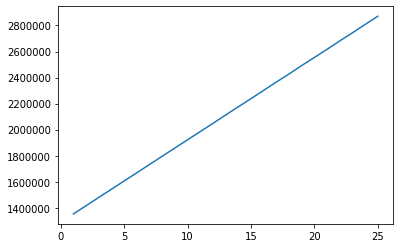

In [145]:
plt.plot(list(range(1, len(results_deploy) + 1)), results_deploy)

### Transaction cost of Verification

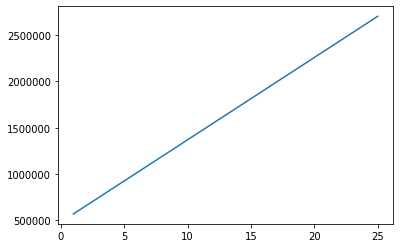

In [146]:
plt.plot(list(range(1, len(results_verify) + 1)), results_verify)